In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,models
import cv2
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import multivariate_normal
from scipy import random, linalg
from sklearn.model_selection import train_test_split
import torch.optim as optim
import re
import json
import time
from tqdm import tqdm_notebook

import sys
from utils import *

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class RealData(Dataset):
    """Dataset containing all sequences with artifacts
    
    Generates three distorted images as input data.
    
    """
    
    def __init__(self, root_dir, indices, sample_size, resize=True):
        self.root_dir = root_dir
        self.ToPIL = transforms.ToPILImage()
        self.ToTensor = transforms.ToTensor()
        self.indices = indices
        self.resize=resize
        self.sample_size = sample_size
        
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):        
        
        idx = self.indices[idx]
        count = 0
        img_files = None
        imgs = None
        label = None
        while True:
            
            n = self.sample_size
            nrs = np.random.choice(range(1,10), size=n, replace=False).tolist()
            img_files = [self.root_dir  +str(idx)+ "/results/img" + str(nr) + ".png" for nr in nrs]
            exists = all([os.path.isfile(img_file) for img_file in img_files])
            count+=1
            try:
                imgs = [cv2.imread(file) for file in img_files]
                imgs = [img[...,::-1]- np.zeros_like(img) for img in imgs]

                label_file = self.root_dir  +str(idx)+ "/results/img0.png"
                label = cv2.imread(label_file)
                label = label[...,::-1]- np.zeros_like(label)
                break

            except:
                idx = np.random.randint(len(self.indices))
                idx = self.indices[idx]

        
        
        if self.resize:
            label = cv2.resize(label, dsize=(256,256))
            imgs = [ cv2.resize(img, dsize=(256,256)) for img in imgs]
        

        H,W,C = imgs[0].shape
        if H<W:
            label = np.rot90(label)
            label -= np.zeros_like(label)
            imgs = [np.rot90(img) for img in imgs]- np.zeros_like(label)
        
        flip = np.random.randint(-1,3)
        if flip < 2:
            label = cv2.flip(label,flip)- np.zeros_like(label)
            imgs = [cv2.flip(img,flip) for img in imgs]- np.zeros_like(label)

        
        imgs = [self.ToTensor(img) for img in imgs]
        #data = torch.unsqueeze(data,0)
        imgs = torch.stack(imgs)
        
        label = label.astype(np.uint8)
        label = self.ToTensor(label)
        #label = torch.unsqueeze(label,0)
        return imgs, label

# Architecture

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=True)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += x
        return out
    
class DilatedResidualBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dilation):
        super(DilatedResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, dilation=dilation, padding=dilation, bias=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, dilation=dilation,padding=dilation, bias=True)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += x
        return out
        
class DeepSetNet(nn.Module):
    """ Deep Set Residual Neural Network """
    def __init__(self, encoder_num_blocks=10, decoder_num_blocks=10, smooth_num_blocks=6, planes=32,block=ResidualBlock ):
        super(DeepSetNet, self).__init__()
        self.planes = planes
        self.input = nn.Conv2d(3, self.planes, kernel_size=3, stride=1, padding=1, bias=True)
        self.output= nn.Conv2d(self.planes, 3, kernel_size=3, stride=1, padding=1, bias=True)
        
        
        # Create a down-/up-sampling architecture
        self.downsample = []
        self.upsample = []
        n = planes
        for i in range(2):
            self.downsample.append( nn.Conv2d(in_channels = n, out_channels=n*2, kernel_size=3, stride=2, padding=1 ) )
            self.downsample.append(nn.ReLU(inplace=True))

            
            self.upsample = [nn.ReLU(inplace=True)] + self.upsample
            self.upsample = [nn.ConvTranspose2d(in_channels=n*2, out_channels=n, kernel_size=3, stride=2, padding=1, output_padding=1)] + self.upsample
            n *= 2

        self.downsample = nn.Sequential(*self.downsample)
        self.upsample = nn.Sequential(*self.upsample)
        
        
        # Embedding of downsampled features
        self.encoder = self._make_layer(block, n, encoder_num_blocks)
        self.decoder = self._make_layer(block, n, decoder_num_blocks)
        self.smooth  = self._make_smooth_layer(planes, smooth_num_blocks)
        
    def _make_layer(self, block, planes, num_blocks):
        layers = []
        for i in range(num_blocks):
            layers.append(DilatedResidualBlock(planes, planes,2))
        return nn.Sequential(*layers)
    
    def _make_smooth_layer(self, planes, num_blocks):
        layers = []
        dilation = 1
        for i in range(num_blocks):
            layers.append(DilatedResidualBlock(planes,planes,dilation))
            if i%2 == 0:
                dilation *= 2
        layers.append( nn.Conv2d(in_channels = planes, out_channels=planes, kernel_size=3, stride=1, padding=1 ) )
        layers.append(nn.ReLU(inplace=True))
        layers.append( nn.Conv2d(in_channels = planes, out_channels=planes, kernel_size=3, stride=1, padding=1 ) )
        return nn.Sequential(*layers)
            
        

    def forward(self, x):
        """Forward pass of our DeepSet Network 
        
        x: of tensor of size (B, S, C, H, W)
        """

        xs = torch.split(x,1,dim = 1)
        xs = [torch.squeeze(x,dim=1) for x in xs]
        embedding = [self.encoder(self.downsample(self.input(x))) for x in xs]
        embedding = torch.stack(embedding).mean(0)
        out = self.output(self.smooth(self.upsample(self.decoder(embedding))))

        
        return out

In [4]:
model_dir = "./modelsReal/"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

print("The following directory will be used in all further steps:  " + model_dir)


# Create Dataset and split it into Training and test set
minibatch_size = 10
data_dir = "SpecShadOccDataset/"

files = os.listdir(data_dir)
match = lambda x: len(re.findall("b\d+", x)) == 1
files = list(filter(match,files))
train, test = train_test_split(files)


#train, test = train_test_split(range(first, first+100))

if os.path.isfile(model_dir + "/train.json"):
    # read training IDs
    f = open(model_dir + "/train.json", "r")
    train = json.loads(f.read())
    f.close()
    
    # read test IDs
    f = open(model_dir + "/test.json", "r")
    test = json.loads(f.read())
    f.close()
    
else:
    f = open(model_dir + "/train.json", "w")
    f.write(json.dumps(train))
    f.close()
    f = open(model_dir + "/test.json", "w")
    f.write(json.dumps(test))
    f.close()

    
if os.path.isfile(model_dir + "/params.json"):
    f = open(model_dir + "/params.json", "r")
    params = json.loads(f.read())
    f.close()
else:
    params = {
        "epoch": 0,
        "time": 0,
    }
    f = open(model_dir + "/params.json", "w")
    f.write(json.dumps(params))
    f.close()


device = torch.device("cuda:0")

# Initialize Neural Network
net = DeepSetNet(encoder_num_blocks=10, decoder_num_blocks=5, planes=18)

if  os.path.isfile(model_dir + "/nn.pt"):
    net.load_state_dict(torch.load(model_dir + "/nn-pretrained.pt"))

net = net.to(device)

criterion = nn.MSELoss()
epochs = 10000

The following directory will be used in all further steps:  ./modelsReal/


In [ ]:
optimizer = optim.Adam(net.parameters(),lr = 0.001,)
optimizer.zero_grad()

def train_or_evaluate(net, data, optimizer, n_samples, mode="train"):
    
    dataset = RealData(data_dir,data,n_samples)
    dataloader = DataLoader(dataset, batch_size=minibatch_size,
                         shuffle=False, num_workers=0)
    error = 0.0
    samples = 0
    if mode == "train":
        net.train()
        for x,y in tqdm_notebook(dataloader, desc ="Training on size "+str(n_samples)):
                #x,y = train_set[i]
                x = x.to(device)
                y = y.to(device)
                output = net.forward(x)
                loss = criterion(output,y)
                error += loss.item()
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                samples += 1
        error =  error/samples
        print("Sample size : %d \t Training Error %f"%(n_samples, error))

    else:
        net.eval()
        with torch.no_grad():
            for x,y in tqdm_notebook(dataloader, desc ="Evaluating on size "+str(n_samples)):
                #x,y = train_set[i]
                x = x.to(device)
                y = y.to(device)
                output = net.forward(x)
                loss = criterion(output,y)
                error +=loss.item()
                samples += 1
        error =  error/samples
        print("Sample size : %d \t Test Error %f"%(n_samples, error))
        
    return error


def training(net, train_ids, test_ids,
             model_dir,optimizer,
             params,
             criterion= nn.MSELoss(),
             epochs=1000,
             device=torch.device("cuda:0")):
    
    last_epoch = params["epoch"]
    t = params["time"]

    
    train_loss = 0
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.1)
    
    # This simulates the Learning rate updates
    for _ in range(last_epoch):
        scheduler.step()
    

    for epoch in range(last_epoch+1,epochs):
        
        start = time.time()
        samples = 0
        train_loss = 0
        
        train_ids = list(train_ids)
        test_ids = list(test_ids)
        np.random.shuffle(train_ids)
        np.random.shuffle(test_ids)
        

        for i in range(1,10):
            train_error = train_or_evaluate(net, train_ids, optimizer, i, mode="train")
            end = time.time()
            t += (end - start)
            write(model_dir + "/train_errors.csv",[epoch,train_error,t])
            torch.save(net.state_dict(), model_dir + "/nn"+str(i)+".pt")
            torch.save(net.state_dict(), model_dir + "/nn.pt")

        
        for i in range(1,10):
            test_error = train_or_evaluate(net, test_ids, optimizer, i, mode="test")
            end = time.time()
            t += (end - start)
            write(model_dir + "/test_errors.csv",[epoch,test_error,t])

        torch.save(net.state_dict(), model_dir + "/nn.pt")
        
        #torch.save(net.state_dict(), model_dir + "/nn"+ str(epoch) +".pt")

        params["epoch"] = epoch
        params["time"] = t
        f = open(model_dir + "/params.json", "w")
        f.write(json.dumps(params))
        f.close()
        #if(train_loss>2*best_loss):
            #net.load_state_dict(torch.load(model_dir + "/nn.pt"))
        scheduler.step()


training(net, train, test,model_dir,optimizer,params,criterion)

In [6]:
trainset = RealData(data_dir,train,9)
dataloader = DataLoader(trainset, batch_size=minibatch_size,
                         shuffle=False, num_workers=0)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


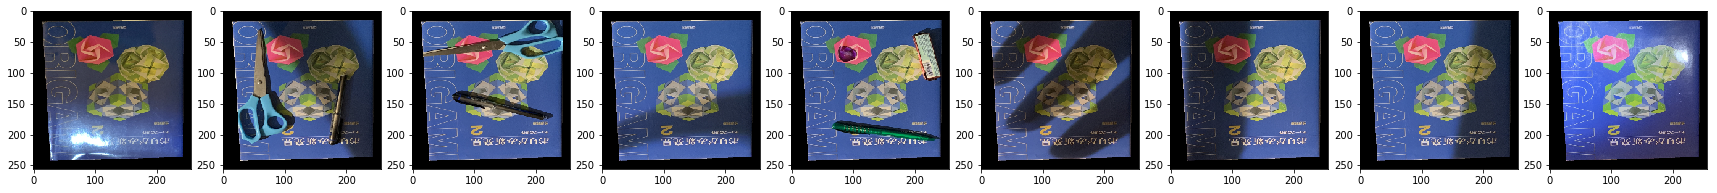

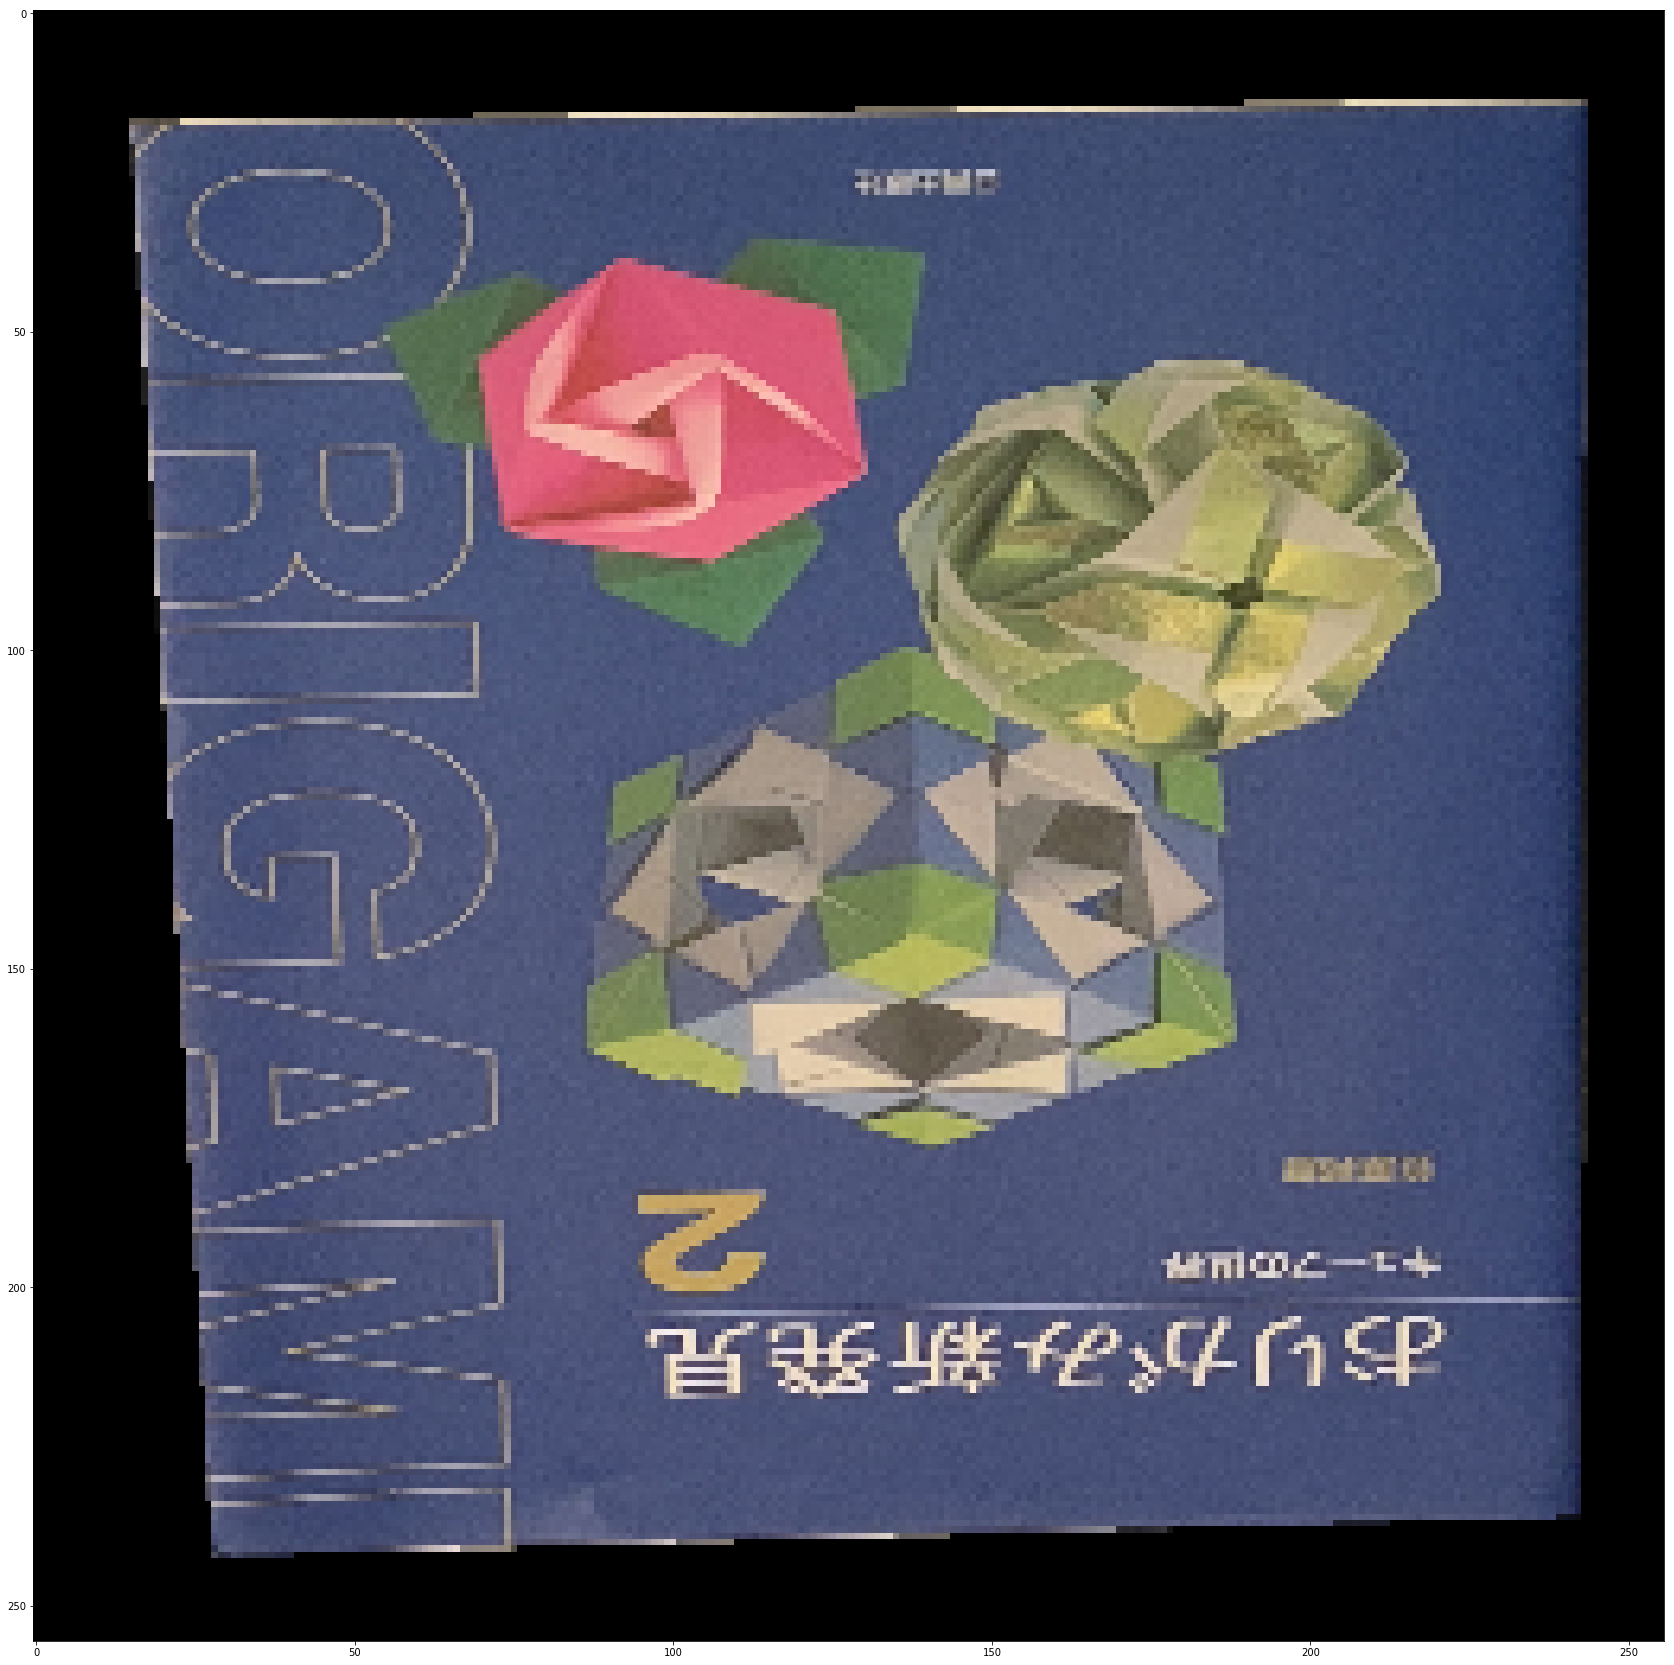

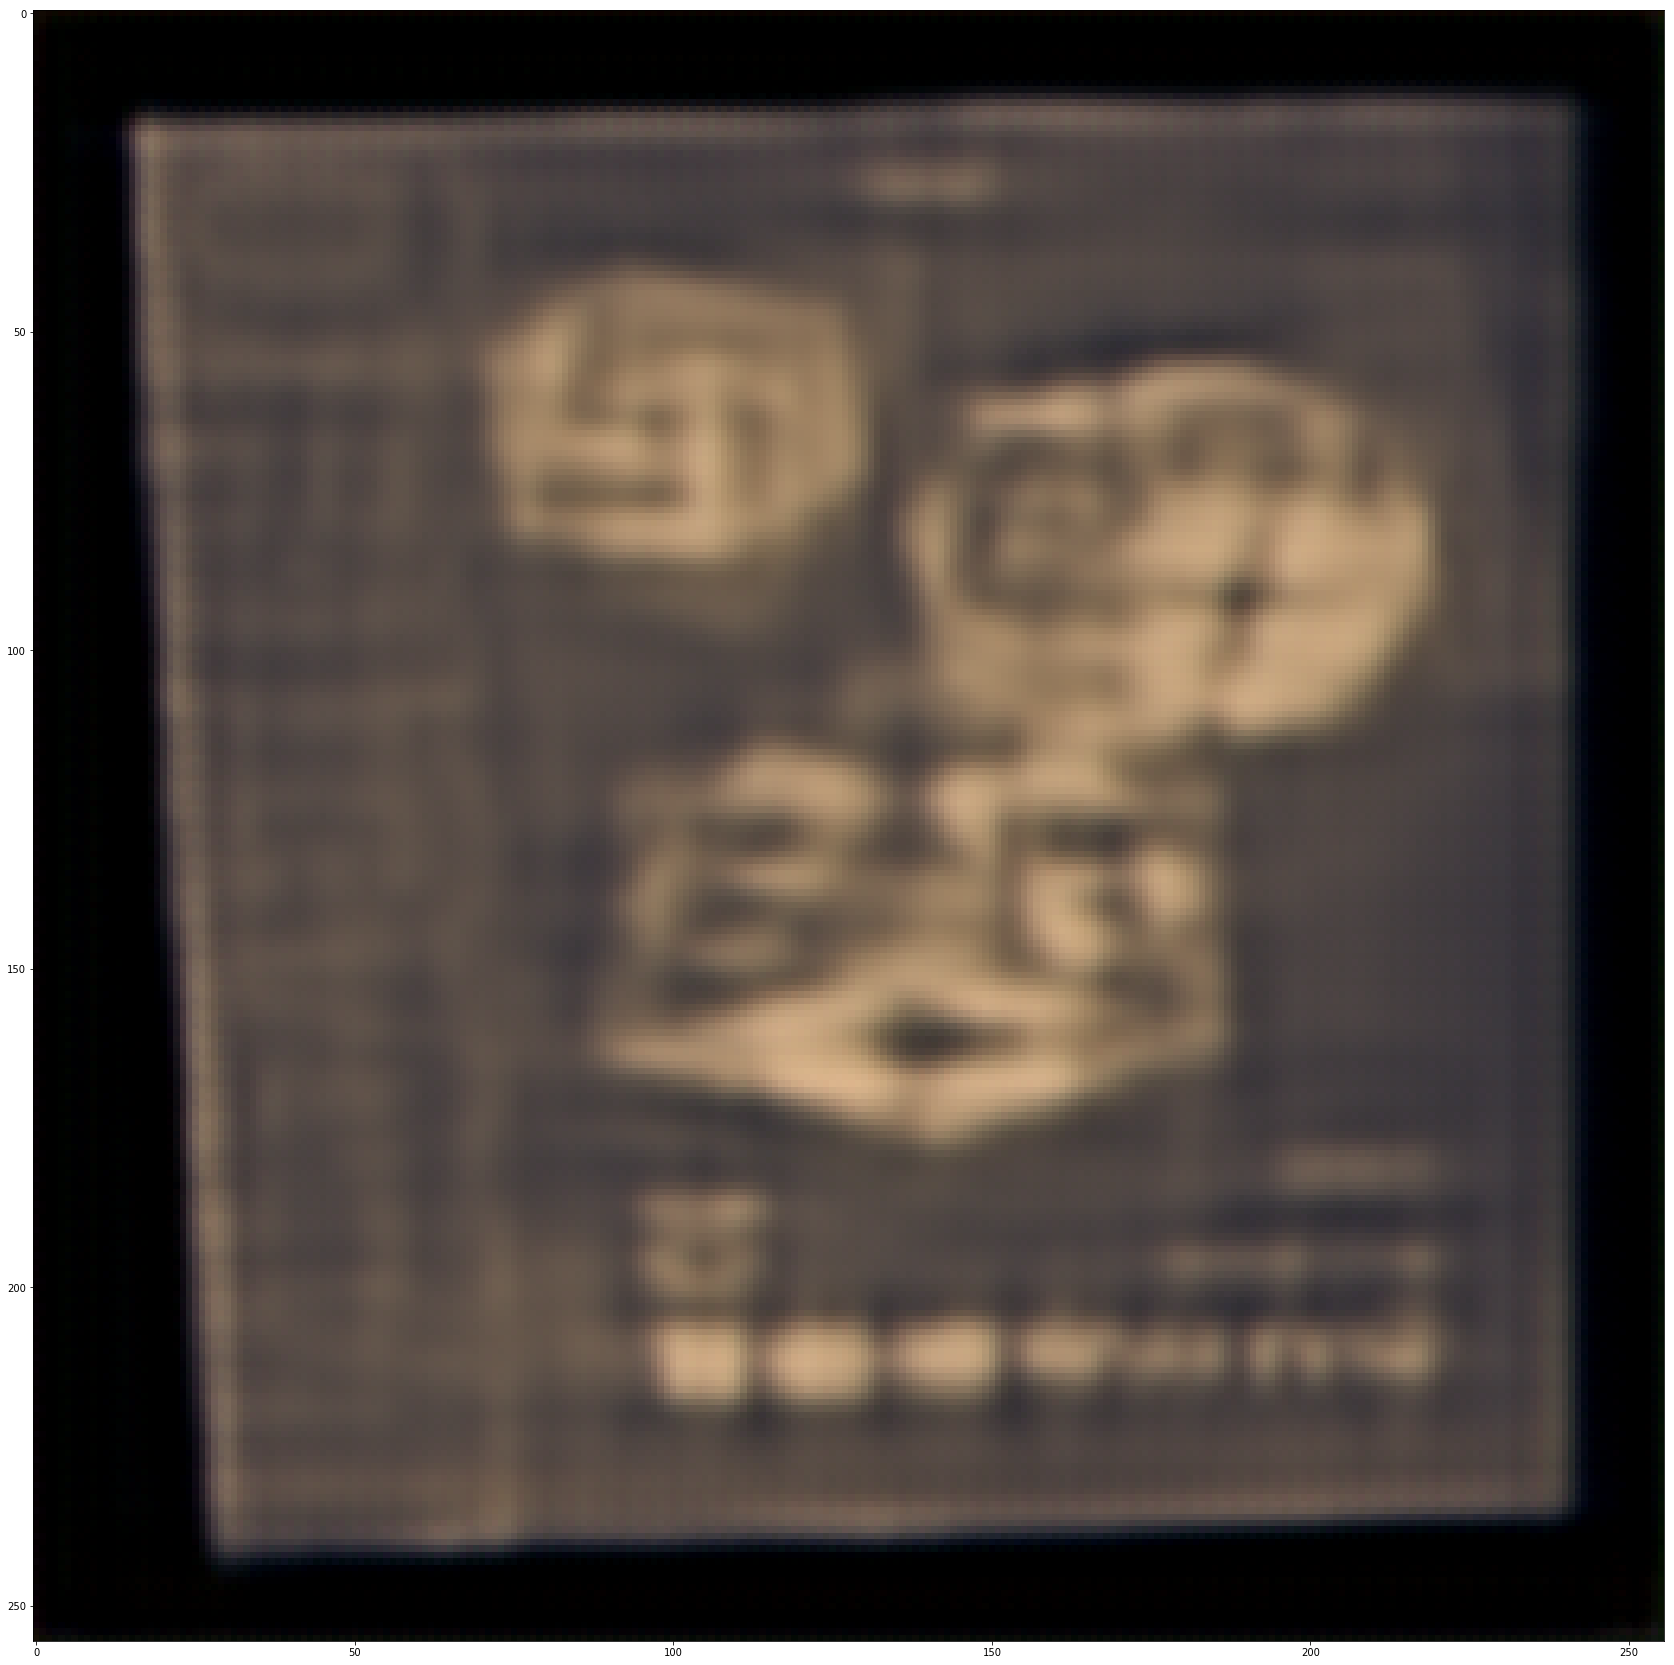

In [15]:
x,y = trainset[10]
x = x.unsqueeze(0)
xs = torch.split(x,1,dim = 1)
xs = [torch.squeeze(x,dim=1) for x in xs]
[print(x.size()) for x in xs]
y = y.unsqueeze(0)
plot(xs)
plot([y])
pred = net(x.cuda())
pred = torch.clamp(pred, 0, 1)
plot([pred.cpu()])

In [16]:
print(pred.min(),pred.max())
print(x.min())

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8651, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.)
